In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp

import networkx as nx

import torch
dtype = torch.float
device = torch.device("cpu")

from utils.utils import *

import utils.dyngdim.dyngdim as dyngdim
from utils.dyngdim.plotting import compute_dim_max, plot_results

In [2]:
def laplacian(A):
    '''
    Calculates the Laplacian matrix of a graph based on its adjacency matrix A.

    Args:
    - A: Adjacency matrix of the graph

    Returns:
    - L: Laplacian matrix of the graph
    '''
    # Calculate the row sums of the adjacency matrix
    K = torch.sum(A, dim=1)
    
    # Construct the Laplacian matrix and return it
    K = torch.diag_embed(K)
    return torch.matmul( torch.inverse(K), K - A )
    #return K - A

def statistical_propagator(L, tau):
    '''
    Computes the statistical propagator matrix using the matrix exponential of the Laplacian and a given time step tau.

    Args:
    - L: Laplacian matrix of the graph
    - tau: Time step

    Returns:
    - U: Statistical propagator matrix
    '''
    return torch.matrix_exp(-tau * L)

def density_matrix(L, tau):
    '''
    Computes the density matrix by normalizing the statistical propagator matrix using its trace.

    Args:
    - L: Laplacian matrix of the graph
    - tau: Time step

    Returns:
    - Density matrix of the system
    '''
    # Compute the statistical propagator matrix
    U = statistical_propagator(L, tau)
    
    # Normalize the matrix by dividing it by its trace and return
    return U / torch.trace(U)

def entropy(L, tau):
    '''
    Computes the von Neumann entropy using the statistical propagator and given time step tau.
    S(rho) = -Tr(rho log(rho)) = -Tr(U/Z log(U/Z))
           = tau / Z * Tr(U@L) + log(Z)

    Args:
    - L: Laplacian matrix of the graph
    - tau: Time step

    Returns:
    - Von Neumann entropy of the system
    '''
    # Compute the statistical propagator matrix
    U = statistical_propagator(L, tau)
    
    # Calculate the trace of the statistical propagator matrix
    Z = torch.trace(U)
    
    # Compute and return the von Neumann entropy formula
    return torch.log(Z) + tau / Z * torch.trace(torch.matmul(U, L))

def efficiency(L, tau):
    '''
    Computes the efficiency of a system in terms of its density matrix.
    eta = 1 + Q / W = ( S - log(Z) ) / ( log(N) - log(Z) )
        = tau / Z * Tr(U@L) / ( log(N) - log(Z) )

    Args:
    - L: Laplacian matrix of the graph
    - tau: Time step

    Returns:
    - Efficiency of the system
    '''
    # Compute the statistical propagator matrix
    U = statistical_propagator(L, tau)
    
    # Calculate the trace of the statistical propagator matrix and the size of the system
    Z = torch.trace(U)
    N = L.size(dim=1)
    
    # Compute and return the efficiency of the system
    return tau / Z * torch.trace(torch.matmul(U, L)) / (np.log(N) - torch.log(Z))

In [3]:
def compute_dimension(Zs, taus):
    D = np.log(Zs)
    D = (D[1:]-D[:-1]) / (np.log(taus)[1:]-np.log(taus)[:-1])
    return -2*D

In [4]:
parc = 200
ses = 1

data = data_loader(which='control', ses=ses, parc=parc, include_subctx=False, thr='mask')

mat = data.load_matrix(0)
    
mat /= mat.max()

######## control - ses 01 - parc 200 - total 29 - thr mask - subctx False ########
- Loading sub-040


In [5]:
parc = 200
ses = 1

control = data_loader(which='control', ses=ses, parc=parc, include_subctx=False, thr='mask')
stroke = data_loader(which='stroke', ses=ses, parc=parc, include_subctx=False, thr='mask')

######## control - ses 01 - parc 200 - total 29 - thr mask - subctx False ########
######## stroke - ses 01 - parc 200 - total 51 - thr mask - subctx False ########


In [78]:
taus = np.logspace(-1.5,2,100)

effs_control = []
effs_stroke = []

for i, mat in enumerate(control):
    if mat is None:
        continue
    mat /= mat.max()
    mat = torch.tensor(mat)
    
    L = laplacian(mat)
    
    tmp_eff = np.array( [torch.trace(statistical_propagator(L,tau)).detach().numpy() for tau in taus] )
    effs_control.append(tmp_eff)

for i, mat in enumerate(stroke):
    if mat is None:
        continue
    mat /= mat.max()
    mat = torch.tensor(mat)
    
    L = laplacian(mat)
    
    tmp_eff = np.array( [torch.trace(statistical_propagator(L,tau)).detach().numpy() for tau in taus] )
    effs_stroke.append(tmp_eff)

- Loading sub-040
- Loading sub-041
- Loading sub-042
- Loading sub-043
- Loading sub-044
- Loading sub-045
- Loading sub-046
- Loading sub-047
- Loading sub-048
- Loading sub-049
- Loading sub-050
- Loading sub-051
- Loading sub-052
- Loading sub-055
- Loading sub-057
- Loading sub-059
- Loading sub-060
- Loading sub-061
- Loading sub-062
- Loading sub-063
- Loading sub-064
- Loading sub-065
- Loading sub-066
- Loading sub-067
- Loading sub-068
- Loading sub-069
- Loading sub-070
- Loading sub-071
- Loading sub-072
- Loading sub-200
- Loading sub-201
- Loading sub-202
- Loading sub-203
- Loading sub-204
- Loading sub-205
- Loading sub-206
- Loading sub-208
- Loading sub-209
- Loading sub-210
- Loading sub-213
- Loading sub-216
- Loading sub-219
- Loading sub-222
- Loading sub-224
- Loading sub-226
- Loading sub-227
- Loading sub-232
- Loading sub-233
- Loading sub-234
- Loading sub-235
- Loading sub-238
- Loading sub-239
- Loading sub-240
- Loading sub-243
- Loading sub-245
- Loading 

In [101]:
d_control = [compute_dimension(Zs, taus) for Zs in effs_control]
d_stroke = [compute_dimension(Zs, taus) for Zs in effs_stroke]

tmin = 2e0
tmax = 1e1
idx = np.where((taus>tmin)*(taus<tmax))[0]

dfit_control = [-2*np.polyfit(np.log(taus)[idx], np.log(Zs)[idx], deg=1)[0] for Zs in effs_control]
dfit_stroke = [-2*np.polyfit(np.log(taus)[idx], np.log(Zs)[idx], deg=1)[0] for Zs in effs_stroke]

In [103]:
df_fit = pd.Series(dfit_control, name="control").to_frame().join(pd.Series(dfit_stroke, name="stroke"))

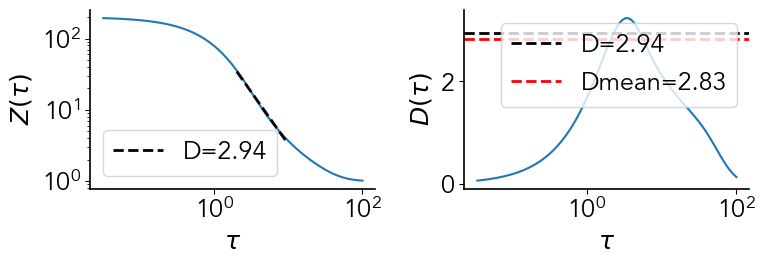

In [118]:
idx_subj = 0
Zs = effs_control[idx_subj]

plt.figure(figsize=(8,3))

tmin = 2e0
tmax = 1e1
idx = np.where((taus>tmin)*(taus<tmax))[0]

m, q = np.polyfit(np.log(taus)[idx], np.log(Zs)[idx], deg=1)
dfit = -2*m

plt.subplot(1,2,1)
plt.plot(taus, Zs )
#plt.plot(taus, effs_stroke[0] )
plt.plot(taus[idx],np.exp(np.log(taus[idx])*m+q), ls='--', c='k', lw=2, label=f'D={np.round(dfit,2)}' )
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$Z(\tau)$')
plt.legend()

plt.subplot(1,2,2)
plt.plot(taus[1:],  d_control[idx_subj])
plt.axhline(dfit, ls='--', lw=2, c='k', label=f'D={np.round(dfit,2)}')
plt.axhline(d_control[idx_subj][idx].mean(), ls='--', lw=2, c='r', label=f'Dmean={np.round(d_control[idx_subj][idx].mean(),2)}')
#plt.plot(taus[1:], D_stroke )
plt.xscale('log')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$D(\tau)$')
plt.legend()

plt.tight_layout()
plt.show()

/home/barzon/.local/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/barzon/.local/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


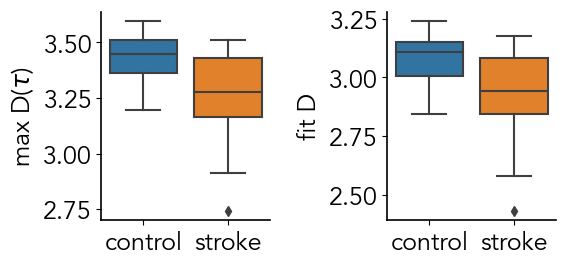

In [116]:
plt.figure(figsize=(6,3))

plt.subplot(1,2,1)
sns.boxplot(data=df)
plt.ylabel(r'max D($\tau$)')

plt.subplot(1,2,2)
sns.boxplot(data=df_fit)
plt.ylabel(r'fit D')

plt.tight_layout()
plt.show()

In [6]:
mat = nx.grid_2d_graph(50, 50)
mat = nx.to_numpy_array(mat)

mat = torch.tensor(mat)

In [7]:
taus = np.logspace(-3,4,100)

L = laplacian(mat)
tmp_eff = np.array( [torch.trace(statistical_propagator(L,tau)).detach().numpy() for tau in taus] )

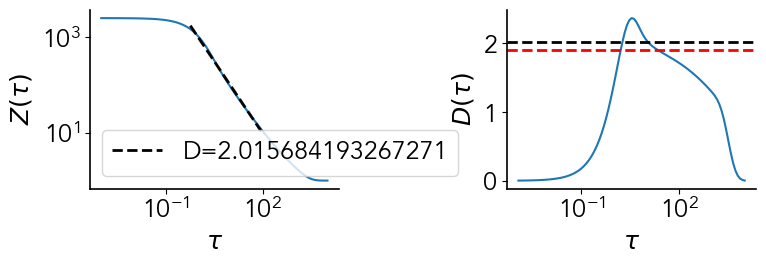

In [9]:
plt.figure(figsize=(8,3))

tmin = 5e-1
tmax = 1e2
idx = np.where((taus>tmin)*(taus<tmax))[0]

m, q = np.polyfit(np.log(taus)[idx], np.log(tmp_eff)[idx], deg=1)
dfit = -2*m

plt.subplot(1,2,1)
plt.plot(taus, tmp_eff )
plt.plot(taus[idx],np.exp(np.log(taus[idx])*m+q), ls='--', c='k', lw=2, label=f'D={dfit}' )
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$Z(\tau)$')
plt.legend()

D = np.log(tmp_eff)
D = (D[1:]-D[:-1]) / (np.log(taus)[1:]-np.log(taus)[:-1])
D = -2*D

plt.subplot(1,2,2)
plt.plot(taus[1:], D )
plt.axhline(dfit, ls='--', lw=2, c='k', label=f'D={np.round(dfit,2)}')
plt.axhline(D[idx].mean(), ls='--', lw=2, c='r', label=f'Dmean={D[idx].mean()}')
#plt.axhline(D[idx].mean(), ls='--', lw=2, c='k')
plt.xscale('log')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$D(\tau)$')

plt.tight_layout()
plt.show()